# Import libraries

In [1]:
import torch

import os
import random
import pandas
import numpy
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# seed = 7777
# random.seed(seed) 
# torch.manual_seed(seed);

# Load Saved MP (Magnetic Parameter) Model

In [2]:
# 12 input -> 42 output
class MpModel(torch.nn.Module):
    def __init__(self):
        super(MpModel, self).__init__()

        self.linear1 = torch.nn.Linear(12, 100, bias=True)
        self.linear2 = torch.nn.Linear(100, 100, bias=True)
        self.linear3 = torch.nn.Linear(100, 42, bias=True)

    def forward(self, x):
        x = torch.atan(self.linear1(x))
        x = torch.atan(self.linear2(x))
        x = torch.atan(self.linear2(x))
        x = self.linear3(x)
        return x


mp_model = MpModel().to("cuda")
mp_model.load_state_dict(torch.load("saved_model_state.pt"))

for param in mp_model.parameters():
    param.requires_grad = False

# Create GP (Geometry Paramter) Generator

In [3]:
class GpModel(torch.nn.Module):
    def __init__(self, input_length: int):
        super(GpModel, self).__init__()

        self.dense_layer1 = torch.nn.Linear(int(input_length), 128)
        self.dense_layer2 = torch.nn.Linear(128, 256)
        self.dense_layer3 = torch.nn.Linear(256, 512)
        self.dense_layer4 = torch.nn.Linear(512, 256)
        self.dense_layer5 = torch.nn.Linear(256, 128)
        self.dense_layer6 = torch.nn.Linear(128, int(input_length))
        
        self.batch_norm1 = torch.nn.LazyBatchNorm1d()
        self.batch_norm2 = torch.nn.LazyBatchNorm1d()
        self.batch_norm3 = torch.nn.LazyBatchNorm1d()
        self.batch_norm4 = torch.nn.LazyBatchNorm1d()
        self.batch_norm5 = torch.nn.LazyBatchNorm1d()

    def forward(self, x):
        x = self.batch_norm1(torch.atan(self.dense_layer1(x)))
        x = self.batch_norm2(torch.atan(self.dense_layer2(x)))
        x = self.batch_norm3(torch.atan(self.dense_layer3(x)))
        x = self.batch_norm4(torch.atan(self.dense_layer4(x)))
        x = self.batch_norm5(torch.atan(self.dense_layer5(x)))
        x = torch.sigmoid(self.dense_layer6(x))
        return x


gp_model = GpModel(10).to("cuda")
optimizer = torch.optim.Adam(gp_model.parameters(), lr=3e-4)

C:\Users\arist\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# System Constraints

In [4]:
# x-direction of the primary winding (mm)
lpx_min, lpx_max = (50.0, 650.0)

# y-direction of the primary winding (mm)
lpy_min, lpy_max = (50.0, 2050.0)

# width of the primary winding (mm)
wp_min, wp_max = (25.0, 325.0)

# length of the edge of the primary core (mm)
a_min, a_max = (0.0, 200.0)

# pitch of the adjacent cores (mm)
p_min, p_max = (0.0, 200.0)

# length of the secondary winding (mm)
ls_min, ls_max = (50.0, 450.0)

# width of the secondary winding (mm)
ws_min, ws_max = (25.0, 225.0)

# input RMS current (A)
ip_min, ip_max = (50.0, 200.0)

# turn number of the primary side
np_min, np_max = (4.0, 10.0)

# turn number of the secondary side
ns_min, ns_max = (4.0, 10.0)

# switching frequency (kHz)
f = 85 * (10 ** 3)

# output power at the center (kW)
p_out = 50 * (10 ** 3)

# input DC voltage (V)
v_dc = 400

# output DC voltage (V)
v_bat = 400

# length of the edge of the secondary core
b = 50

# ???
w = 2 * numpy.pi * f  # [rad/s]

# ???
q_coil = 400

# Helper functions

In [5]:
# Creates a tensor of shape [num, *start.shape] whose values are evenly spaced from start to end, inclusive.
# Replicates but the multi-dimensional bahaviour of numpy.linspace in PyTorch.

@torch.jit.script
def linspace(start: torch.Tensor, stop: torch.Tensor, num: int):
    # create a tensor of 'num' steps from 0 to 1
    steps = torch.arange(num, dtype=torch.float32, device=start.device) / (num - 1)

    # reshape the 'steps' tensor to [-1, *([1]*start.ndim)] to allow for broadcastings
    # - using 'steps.reshape([-1, *([1]*start.ndim)])' would be nice here but torchscript
    #   "cannot statically infer the expected size of a list in this contex", hence the code below
    for i in range(start.ndim):
        steps = steps.unsqueeze(-1)

    # the output starts at 'start' and increments until 'stop' in each dimension
    out = start[None] + steps * (stop - start)[None]

    return out

In [6]:
# Generate a pytorch tensor full of random floats in the range [-1, +1] with the given shape

def generate_noise(shape):
    return torch.distributions.uniform.Uniform(-1, +1).sample(shape).cuda()

In [7]:
def stack_parameters(*params):
    return torch.stack(params).transpose(0, 1)


# Scale an array to be between our specified [min, max] contraints
def scale(arr):
    scaler_min = torch.tensor(
        [a_min, lpx_min, lpy_min, ls_min, p_min, wp_min, ws_min, ip_min, np_min, ns_min],
        device="cuda",
    )
    scaler_max = torch.tensor(
        [a_max, lpx_max, lpy_max, ls_max, p_max, wp_max, ws_max, ip_max, np_max, ns_max],
        device="cuda",
    )

    return arr * (scaler_max - scaler_min) + scaler_min


def extract(arr):
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns = [
        numpy.squeeze(x) for x in numpy.hsplit(arr, 10)
    ]

    ys_min = (
        5 * wp +
        4 * a +
        3 * lpy +
        2 * p
    )

    ys_max = (lpy + wp)
    ys_max = ys_min + (ys_min - ys_max) / 2

    ys_min /= 2
    ys_max /= 2

    ys = linspace(ys_min, ys_max, num=5)

    np = torch.round(np)
    ns = torch.round(ns)

    # take all 15 tensors of shape (X) and convert to (15, X)
    return a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys


def scale_and_extract(arr):
    scaled_array = scale(arr)
    return extract(scaled_array)

In [8]:
# Enclose in a function so we don't leak variables
def test_models():
    noise = generate_noise(shape=(256, 10))
    gp = gp_model(noise)
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)

    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns)

    mp = mp_model(gp_parameters)

    print(f"""
    GP Parameters Shape:    {gp_parameters.shape}
    Extra Parameters Shape: {extra_parameters.shape}
    MP Model Output Shape:  {mp.shape}
    """)
test_models()


    GP Parameters Shape:    torch.Size([256, 12])
    Extra Parameters Shape: torch.Size([256, 3])
    MP Model Output Shape:  torch.Size([256, 42])
    


In [9]:
"""
Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.
"""


def pareto_frontier(x, y, max_x=False):
    if max_x:
        return _pareto_frontier(y, x)
    else:
        return _pareto_frontier(x, y)


def _pareto_frontier(x, y):
    # Combine inputs and sort them with smallest X values coming first
    sorted_xy = sorted(zip(x, y))
    p_front_x = torch.zeros(len(x), device="cuda")
    p_front_y = torch.zeros(len(y), device="cuda")
    
    # Loop through the sorted list
    #   Look for lower values of Y…
    #   and add them to the Pareto frontier
    min_y = sorted_xy[0][1]
    for index in range(len(sorted_xy)):
        x, y = sorted_xy[index]
        if y < min_y:
            min_y = y
            p_front_x[index] = x
            p_front_y[index] = y
            
    p_front_x = p_front_x[p_front_x.nonzero()]
    p_front_y = p_front_y[p_front_y.nonzero()]

    return p_front_x, p_front_y

In [10]:
def y_util(x, a, b, c):
    return (1 / (a * (x**b)))**c

# Load DWPT data

In [11]:
def load_dwpt():
    folder_name = "./dwpt_v5"
    file_names = [
        "DWPT_v5_N10",
        "DWPT_v5_N100",
        "DWPT_v5_N200",
        "DWPT_v5_N300",
        "DWPT_v5_N400",
    ]

    df = pandas.DataFrame()

    for file_name in file_names:
        new_df = pandas.read_csv(f"{folder_name}/{file_name}_after.csv", index_col=0)
        df = pandas.concat([df, new_df])

    return df

df = load_dwpt()
df_gp = df.loc[:, :"ys4[mm]"]
df_mp = df.loc[:, "k0mm_ys0":]

print(df_gp.shape)
print(df_mp.shape)

(1010, 12)
(1010, 42)


# Define Loss Functions

In [12]:
def kdiff_loss(k_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters

    kdiff = abs(k_0_0 - k_1_0)
    kdiff = kdiff / torch.max(abs(k_0_0), abs(k_1_0))

    # their kdiff - why is there a difference?
    #   kdiff = abs(k00 - k10) / k00

    return kdiff



def bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters):
    # Unpack parameters
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters
    (
        bx_p_0_00, by_p_0_00, bz_p_0_00,
        bx_p_0_90, by_p_0_90, bz_p_0_90,
        bx_s_0_00, by_s_0_00, bz_s_0_00,
        bx_s_0_90, by_s_0_90, bz_s_0_90,

        bx_p_1_00, by_p_1_00, bz_p_1_00,
        bx_p_1_90, by_p_1_90, bz_p_1_90,
        bx_s_1_00, by_s_1_00, bz_s_1_00,
        bx_s_1_90, by_s_1_90, bz_s_1_90,
    ) = b_parameters
    (
        ip, np, ns
    ) = extra_parameters

    # Scale l_parameters
    lp_0_0 = lp_0_0 * np ** 2
    ls_0_0 = ls_0_0 * ns ** 2

    # Calculate Is
    # n1 = (numpy.pi * w) * (lp_0_0 * 10 ** -9) * (ip * numpy.sqrt(2) / (4 * v_dc))
    # t1 = (numpy.pi) ** 2 * w * (lp_0_0 * 10 ** -9 * ls_0_0 * 10 ** -9) ** 0.5
    # t2 = p_out / (8 * k_0_0 * n1 * v_dc * v_bat)
    # n2 = t1 * t2
    # # "Is" is way too big?
    # Is = 4 * n2 * v_bat / (numpy.pi * w * ls_0_0 * 10 ** -9) / numpy.sqrt(2)
    
    # Paper formula
    n1 = (torch.pi * w * lp_0_0 * ip) / (2 * numpy.sqrt(2) * v_dc)
    t1 = (torch.pi ** 2 * w * p_out * torch.sqrt(lp_0_0 * ls_0_0))
    t2 = 8 * k_0_0 * n1 * v_dc * v_bat
    n2 = t1 / t2
    Is = (4 * v_bat * n2) / (torch.pi * w * ls_0_0)

    # Calculate B_0mm - unneeded since b100mm always bigger?
    # bx_0 = (
    #     (bx_p_0_00 * ip * np + bx_s_0_00 * Is * ns) ** 2 +
    #     (bx_p_0_90 * ip * np + bx_s_0_90 * Is * ns) ** 2
    # ) ** 0.5
    # by_0 = (
    #     (by_p_0_00 * ip * np + by_s_0_00 * Is * ns) ** 2 +
    #     (by_p_0_90 * ip * np + by_s_0_90 * Is * ns) ** 2
    # ) ** 0.5
    # bz_0 = (
    #     (bz_p_0_00 * ip * np + bz_s_0_00 * Is * ns) ** 2 +
    #     (bz_p_0_90 * ip * np + bz_s_0_90 * Is * ns) ** 2
    # ) ** 0.5
    # b_0 = (bx_0**2 + by_0**2 + bz_0**2) ** 0.5

    # Calculate B_100mm
    bx_100 = (
        (bx_p_1_00 * ip * np + bx_s_1_00 * Is * ns) ** 2 +
        (bx_p_1_90 * ip * np + bx_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    by_100 = (
        (by_p_1_00 * ip * np + by_s_1_00 * Is * ns) ** 2 +
        (by_p_1_90 * ip * np + by_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    bz_100 = (
        (bz_p_1_00 * ip * np + bz_s_1_00 * Is * ns) ** 2 +
        (bz_p_1_90 * ip * np + bz_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    b_100 = (bx_100**2 + by_100**2 + bz_100**2) ** 0.5

    # Bstray is the max between the two targets
    # bstray = torch.max(b_0, b_100)
    bstray = b_100

    return bstray

In [13]:

#     (
#         # [0 thru 5]
#         k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,

#         # [6 thru 17]
#         lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
#         ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
#         lp_1_0, ls_1_0,

#         # [18 thru 29]
#         bx_p_0_00, by_p_0_00, bz_p_0_00,
#         bx_p_0_90, by_p_0_90, bz_p_0_90,
#         bx_s_0_00, by_s_0_00, bz_s_0_00,
#         bx_s_0_90, by_s_0_90, bz_s_0_90,

#         # [30 thru 42]
#         bx_p_1_00, by_p_1_00, bz_p_1_00,
#         bx_p_1_90, by_p_1_90, bz_p_1_90,
#         bx_s_1_00, by_s_1_00, bz_s_1_00,
#         bx_s_1_90, by_s_1_90, bz_s_1_90,
#     )

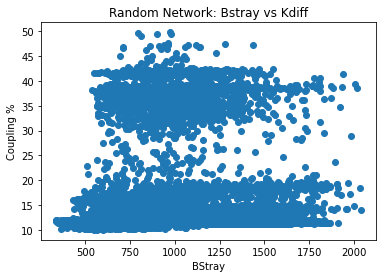

In [14]:
noise = generate_noise(shape=(25_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

plt.scatter(bstray.detach().cpu(), 100 * kdiff.detach().cpu())
plt.title("Random Network: Bstray vs Kdiff")
plt.xlabel("BStray")
plt.ylabel("Coupling %")
plt.show()

# Neural Network Training Loop

In [23]:
p_front_x = []
p_front_y = []
pareto_bstray_points = []
pareto_kdiff_points = []

kdiffs = []
bstrays = []
combined_losses = []

for epoch in range(1000):
    # Clear old gradients in the GP model
    for param in gp_model.parameters():
        param.grad = None

    # Create GP parameters from noise
    noise = generate_noise(shape=(256, 10))
    gp = gp_model(noise)

    # Unpack and filter GP parameters
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

    # Scale GP parameters - why?
    min_x = torch.min(gp_parameters)
    max_x = torch.max(gp_parameters)
    gp_parameters = (gp_parameters - min_x) / (max_x - min_x)

    # Push GP parameters through MP model
    mp_parameters = mp_model(gp_parameters)

    # Scale MP parameters
    y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
    min_y = torch.min(y, 1).values
    max_y = torch.max(y, 1).values
    mp_parameters = mp_parameters * (max_y - min_y) + min_y

    k_parameters = mp_parameters.transpose(0, 1)[0:6]
    l_parameters = mp_parameters.transpose(0, 1)[6:18]
    b_parameters = mp_parameters.transpose(0, 1)[18:]

    # Calculate losses
    kdiff = kdiff_loss(k_parameters)
    bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
    pareto_bstray, pareto_kdiff = pareto_frontier(bstray, kdiff)

    # Scale losses
    kdiff = kdiff / .15
    bstray = bstray / 45
    pareto_bstray, pareto_kdiff = pareto_bstray / 45, pareto_kdiff / .15

    pareto_bstray_numpy = pareto_bstray.cpu().data.numpy()
    pareto_kdiff_numpy = pareto_kdiff.cpu().data.numpy()

    #compute delta y loss from utility fit function

    if len(pareto_bstray_numpy) > 2:
        popt, pcov = curve_fit(y_util, pareto_bstray_numpy[:,0], pareto_kdiff_numpy[:,0], maxfev = 3000)

        y_calc = torch.as_tensor(((1 /popt[0] * (pareto_bstray_numpy[:,0]**popt[1]))**popt[2])).cuda()
        y_loss = pareto_kdiff[:,0] - y_calc
        #y_loss = y_calc - pareto_kdiff[:,0]
    elif len(pareto_bstray_numpy) > 0:
        y_loss = pareto_kdiff[:,0]

    # loss
    #print(len(pareto_bstray))
    #print(len(pareto_bstray.size()))

    if len(pareto_bstray) > 0 and len(pareto_kdiff) > 0:
        combined_loss = torch.mean(torch.log(y_loss) + 1)
    else: 
        combined_loss = torch.mean(
            bstray +
            kdiff
        )
        print('used mean')

    # Push loss through the optimizer and update the GP model
    try:
        combined_loss.backward(retain_graph=True)
        optimizer.step()
    except Exception as e:
        print(f"Error on epoch {epoch} regarding", e)
        break

    # Log losses and other metrics
    if epoch % 100 == 0:

        # Store metrics for plotting or further logging
        combined_losses.append(combined_loss.cpu().data.numpy())
        kdiffs.append(.15 * torch.mean(kdiff).cpu().data.numpy())
        bstrays.append(45 * torch.mean(bstray).cpu().data.numpy())
        p_front_x.append(45 * pareto_bstray)
        p_front_y.append(.15 * pareto_kdiff)
        pareto_bstray_points.append(45 * pareto_bstray[:].cpu().detach().numpy())
        pareto_kdiff_points.append(.15 * pareto_kdiff[:].cpu().detach().numpy())


        print(f"Epoch: {epoch:4d}")
        print(f"  Combined Loss:  {combined_losses[-1]:.10f}")
        print(f"  Kdiff :         {100 * kdiffs[-1]:.4f}%")
        print(f"  Bstray :        {bstrays[-1]:.4f}")
        print(f"  Pareto Kdiff :  {100 * torch.mean(p_front_y[-1]).cpu().data.numpy():.4f}%")
        print(f"  Pareto Bstray : {torch.mean(p_front_x[-1]).cpu().data.numpy():.4f}")

        # Save model for further training or testing
        torch.save(gp_model, f"./models/gp_model_{epoch:06}.pt")

C:\Users\arist\AppData\Local\Temp\ipykernel_23496\908143299.py:60: RuntimeWarning: overflow encountered in power
  y_calc = torch.as_tensor(((1 /popt[0] * (pareto_bstray_numpy[:,0]**popt[1]))**popt[2])).cuda()


Epoch:    0
  Combined Loss:  nan
  Kdiff :         36.5279%
  Bstray :        43.6414
  Pareto Kdiff :  5.0628%
  Pareto Bstray : 28.3706
used mean


C:\Users\arist\AppData\Local\Temp\ipykernel_23496\908143299.py:60: RuntimeWarning: divide by zero encountered in power
  y_calc = torch.as_tensor(((1 /popt[0] * (pareto_bstray_numpy[:,0]**popt[1]))**popt[2])).cuda()
C:\Users\arist\AppData\Local\Temp\ipykernel_23496\2221788931.py:2: RuntimeWarning: invalid value encountered in power
  return (1 / (a * (x**b)))**c


Epoch:  100
  Combined Loss:  -2.4977579117
  Kdiff :         40.9956%
  Bstray :        44.2454
  Pareto Kdiff :  5.0133%
  Pareto Bstray : 29.0485
used mean
used mean
used mean
used mean
Epoch:  200
  Combined Loss:  -0.1196818352
  Kdiff :         34.8124%
  Bstray :        43.5081
  Pareto Kdiff :  4.8958%
  Pareto Bstray : 25.6637
used mean
used mean
used mean
used mean
used mean
used mean
used mean
used mean
used mean
used mean
used mean
used mean
used mean
used mean
used mean
Epoch:  300
  Combined Loss:  nan
  Kdiff :         30.7340%
  Bstray :        41.6774
  Pareto Kdiff :  5.0156%
  Pareto Bstray : 22.5319
used mean
used mean
used mean
used mean
used mean
used mean
used mean
Epoch:  400
  Combined Loss:  -0.1112236977
  Kdiff :         25.6232%
  Bstray :        40.6146
  Pareto Kdiff :  4.9373%
  Pareto Bstray : 22.9630
used mean
used mean
used mean
used mean
used mean
used mean
used mean
used mean
used mean
Epoch:  500
  Combined Loss:  nan
  Kdiff :         26.2743%
  B

# Plotting

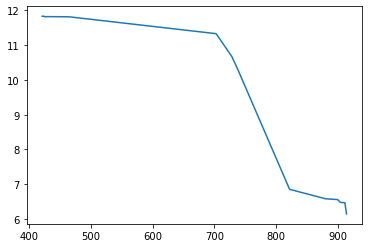

In [24]:
noise = generate_noise(shape=(10_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

pareto_bstray, pareto_kdiff = pareto_frontier(bstray, kdiff)
pareto_kdiff = pareto_kdiff * 100

plt.plot(pareto_bstray.detach().cpu(), pareto_kdiff.detach().cpu())

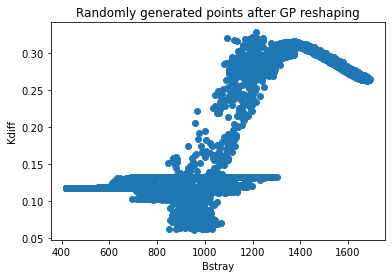

In [25]:
noise = generate_noise(shape=(25_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

plt.scatter(bstray.detach().cpu(), kdiff.detach().cpu())
plt.title("Randomly generated points after GP reshaping")
plt.xlabel("Bstray")
plt.ylabel("Kdiff")
plt.show()

In [26]:
noise = generate_noise(shape=(3, 10))
gp = gp_model(noise)

noise = noise.cpu().numpy()
gp = gp.cpu().detach().numpy()

for i in range(3):
    print(f"Noise {i}")
    print(noise[i])
    print()
    print(f"Generated Parameters {i}")
    print(gp[i])
    print()

Noise 0
[ 0.55158424 -0.745013    0.69308853  0.5083493  -0.35753787 -0.7390202
  0.29427218 -0.14863455  0.15522993 -0.05299556]

Generated Parameters 0
[0.41420674 0.20676552 0.2415155  0.18481441 0.4620031  0.2879369
 0.68172616 0.68171865 0.50589395 0.43833435]

Noise 1
[ 0.07366049 -0.2933091   0.86262023 -0.46959186 -0.18674314  0.7915963
 -0.01342487  0.37547565 -0.2495724   0.08281946]

Generated Parameters 1
[0.80738544 0.9987062  0.9934889  0.99783546 0.34047693 0.96500677
 0.14728576 0.04173407 0.294474   0.774755  ]

Noise 2
[-0.905509    0.7487302   0.42231274 -0.56126916  0.3108945  -0.84638834
 -0.24407852 -0.7154496  -0.16614842 -0.15136397]

Generated Parameters 2
[0.30330187 0.00616231 0.01908658 0.00834554 0.59665334 0.11177728
 0.58564675 0.80347705 0.7338309  0.29548874]



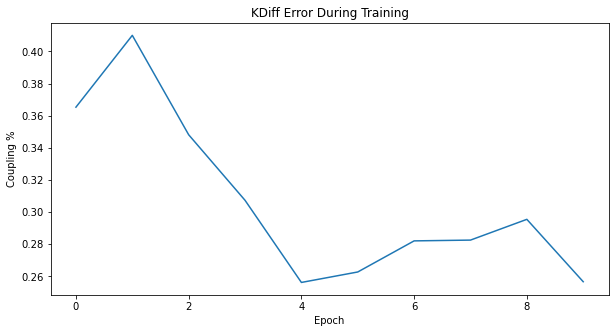

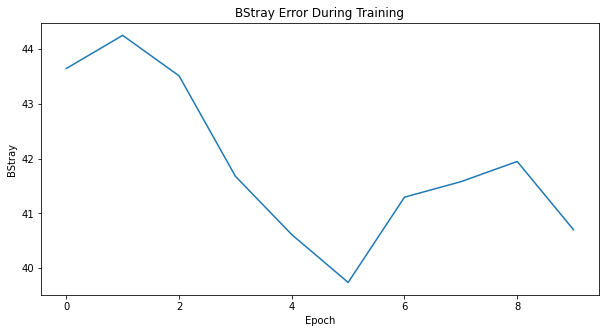

In [27]:
plt.figure(figsize=(10, 5))
plt.title(f"KDiff Error During Training")
plt.xlabel("Epoch")
plt.ylabel("Coupling %")

plt.plot(numpy.arange(len(kdiffs)), kdiffs)
plt.show()


plt.figure(figsize=(10, 5))
plt.title(f"BStray Error During Training")
plt.xlabel("Epoch")
plt.ylabel("BStray")

plt.plot(numpy.arange(len(bstrays)), bstrays)
plt.show()

10 10


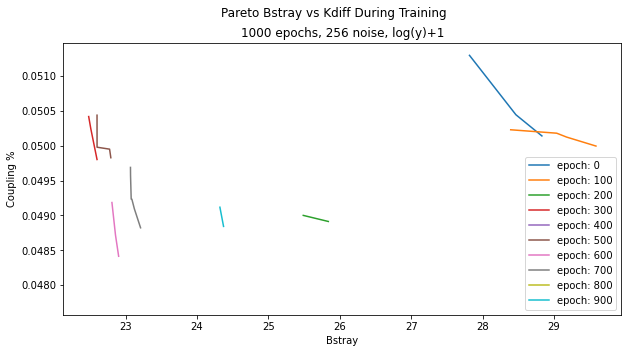

'\nplt.figure(figsize=(10, 5))\nplt.title(f"Pareto Kdiff During Training")\nplt.xlabel("Epoch")\nplt.ylabel("Coupling %")\n\nfor x in pareto_kdiff_points:\n    plt.plot(x)\nplt.show()\n'

<Figure size 432x288 with 0 Axes>

In [30]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff During Training")
plt.title("1000 epochs, 256 noise, log(y)+1")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")

print(len(pareto_bstray_points), len(pareto_kdiff_points))

while i < len(pareto_bstray_points):
    plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    i+=1
plt.legend()
plt.show()
#plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_log(y)+1.png')

'''
plt.figure(figsize=(10, 5))
plt.title(f"Pareto Kdiff During Training")
plt.xlabel("Epoch")
plt.ylabel("Coupling %")

for x in pareto_kdiff_points:
    plt.plot(x)
plt.show()
'''

In [29]:
print(p_front_x)

[tensor([[27.8159],
        [28.4659],
        [28.8300]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[28.3933],
        [29.0372],
        [29.1763],
        [29.5872]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[25.4882],
        [25.8391]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[22.4831],
        [22.5128],
        [22.5999]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[22.9630]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[22.5999],
        [22.6004],
        [22.7757],
        [22.7932]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[22.8087],
        [22.8585],
        [22.9026]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[23.0683],
        [23.0693],
        [23.0784],
        [23.0878],
        [23.1225],
        [23.2096]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[23.2174]], device='cuda:0', grad_fn=<MulBackward0>), tensor([[24.3207],
        [24.3717]], device='cuda:0', grad_fn=<MulBackward0>)]
